# Lab 4

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import scipy
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy.signal
import matplotlib.cm as cm
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (315.25564228, 69.37728343)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (315.62115387, 70.66807018)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (316.0069949, 71.95580151)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (316.41659706, 73.24032877)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (316.85450307, 74.52149636)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (317.32685502, 75.79913919)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (317.84216578, 77.07307859)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (318.41258488, 78.3431158)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (319.05607288, 79.60902077)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (319.80034642, 80.87051186)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (320.69053705, 82.12721658)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
   

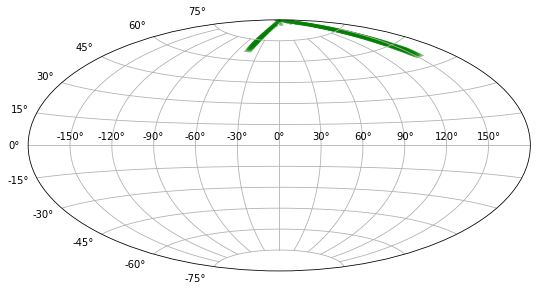

In [28]:
# (l = 105◦ to 160◦),(b = 15◦ to 50◦)

dg = u"\N{DEGREE SIGN}"

def plot_FOV(ax, color, label):
    
    FOV = (5 * (np.pi/180))/ 2 #set by the telescope. We have a 10 degree field of view
    
    xarr = np.linspace(105, 160, 50)
    yarr = np.linspace(15, 50, 50)
    for i in range(50):
        x, y = xarr[i], yarr[i]
        gal = SkyCoord(x*u.degree, y*u.degree, frame='galactic')
        ra_dec = gal.transform_to('fk5')
        print(ra_dec)
    #     gal = eq.galactic
    #     print(gal.l)

    #     ax.scatter(gal.l,gal.b,alpha=0.5,marker="s",s=200,color=color, label=label)
        ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                     edgecolor = color,
                     facecolor = color,
                     alpha=0.5,
                     fill=True,
                     lw=3))
    

f = plt.figure(figsize=(9,5.5))

ax = plt.subplot(111, projection='aitoff')
ax.grid(True)

plot_FOV(ax, color="green", label="Target")
# plot_FOV(ax, RA_z, DEC_z, color="blue", label="Calibration")